## Reproductible fitting 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from jmstate import MultiStateJointModel
from jmstate.functions import gamma_plus_b, sigmoid, weibull
from jmstate.types import *
from jmstate.utils import *
from uniformbands import get_bands

torch.manual_seed(0)

In [2]:
sigmoid = torch.jit.script(sigmoid)


@torch.jit.script
def f(gamma, x, b):
    psi = gamma_plus_b(gamma, x, b)
    psi[:, 1].exp_()
    return psi

In [3]:
lmda = 6
k = 2

gamma = torch.tensor([4.0, -0.5, 6.0])

Q = torch.diag(torch.tensor([1.0, 0.1, 1.0]))
Q_flat = flat_from_cov(Q, method="diag")

R = torch.diag(torch.tensor([0.3]))
R_flat = flat_from_cov(R, method="ball")

alphas = {
    (0, 1): torch.tensor([1.7]),
}
betas = {
    (0, 1): torch.tensor([-1.34, 2.5, 3.2]),
}

real_params = ModelParams(gamma, (Q_flat, "diag"), (R_flat, "ball"), alphas, betas)

In [4]:
weibull_fn = weibull(k, lmda)

surv = {
    (0, 1): (weibull_fn, sigmoid),
}

model_design = ModelDesign(f, sigmoid, surv)

In [5]:
real_model = MultiStateJointModel(model_design, real_params, n_quad=128)

n, p = 500, 3

# Generate training set
t = torch.linspace(0, 15, 25)
c = torch.rand(n) * 5 + 10
x = torch.randn(n, p)
b = torch.randn(n, real_params.gamma.shape[0]) @ torch.linalg.cholesky(Q)
psi = f(real_params.gamma, x, b)

In [6]:
trajectories_init = [[(0.0, 0)] for _ in range(n)]
sample_data = SampleData(x, trajectories_init, psi)
trajectories = real_model.sample_trajectories(sample_data, c)

In [7]:
c_min = torch.tensor(
    [
        (
            min(c[i].item(), trajectories[i][-1][0])
            if trajectories[i][-1][1] == 1
            else c[i].item()
        )
        for i in range(len(trajectories))
    ]
)

In [8]:
y = model_design.regression_fn(t, psi)
y += torch.randn_like(y) * torch.sqrt(R)
y[t.repeat(n, 1) > c.view(-1, 1)] = torch.nan

In [9]:
init_params = ModelParams(
    torch.zeros_like(gamma),
    (torch.zeros_like(Q_flat), "diag"),
    (torch.zeros_like(R_flat), "ball"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

In [10]:
data = ModelData(x, t, y, trajectories, c)

In [11]:
buckets = build_buckets(trajectories)
print([(key, buckets[key][0].numel()) for key in buckets.keys()])

[((0, 1), 478)]


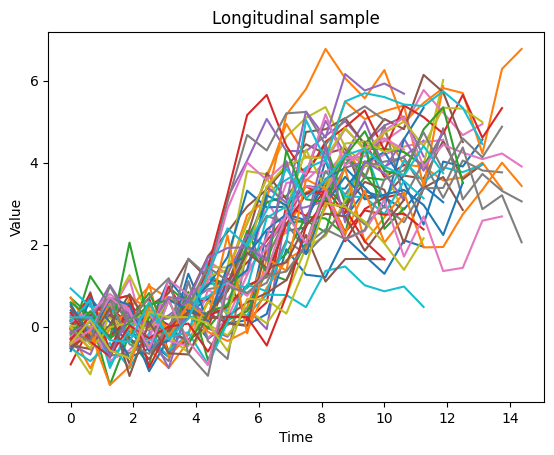

In [12]:
plt.plot(t, y[:50].squeeze(-1).T)
plt.title("Longitudinal sample")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [ ]:
history = []

callback = lambda info: history.append([p.detach().clone() for p in info["params"].as_list])

from jmstate.callbacks import *

model = MultiStateJointModel(model_design, init_params)
model.fit(data, callbacks=callback, n_iter=500),
model.get_metrics(callbacks=[compute_criteria, compute_ebes])

Running metrics loop: 100%|██████████| 1000/1000 [00:07<00:00, 136.92it/s]


{'fim': tensor([[ 4.6919e+03, -1.0002e+03, -1.8575e+03,  9.8575e+01, -7.5405e+00,
          -1.7810e+01,  1.3546e+02,  2.6728e+02,  6.2195e+01, -5.3623e+01,
          -5.2052e+01],
         [-1.0002e+03,  1.6298e+03,  2.2171e+02, -3.7086e+00,  3.4050e+01,
          -1.7373e+01, -6.1147e+01, -1.1948e+02, -1.8593e+01,  1.6803e+01,
           3.6626e+01],
         [-1.8575e+03,  2.2171e+02,  4.2419e+03, -2.9033e+01, -4.5243e+01,
           5.8520e+01, -3.7009e+02, -3.2104e+02, -3.7292e+01,  6.5454e+01,
           5.1426e+01],
         [ 9.8575e+01, -3.7086e+00, -2.9033e+01,  5.0652e+01,  2.1087e+00,
          -1.5101e+00,  4.4267e+01, -5.4485e-01, -2.6157e+00,  4.1418e+00,
          -1.5216e+00],
         [-7.5405e+00,  3.4050e+01, -4.5243e+01,  2.1087e+00,  2.4023e+02,
          -3.0284e+00, -4.8936e+01,  9.8410e+00, -8.4337e+00, -1.2838e+00,
          -2.1764e+00],
         [-1.7810e+01, -1.7373e+01,  5.8520e+01, -1.5101e+00, -3.0284e+00,
           2.5778e+01, -2.5750e+01, -2.6727e+00,

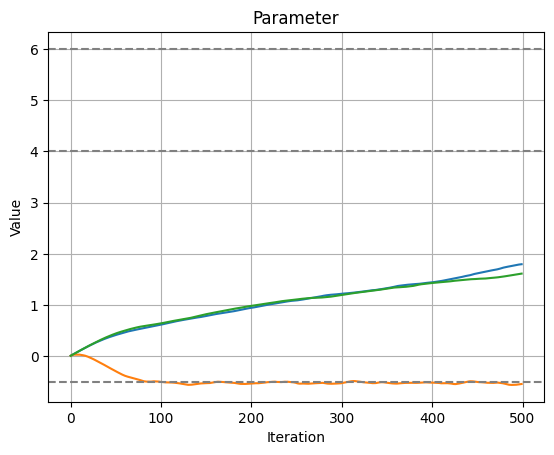

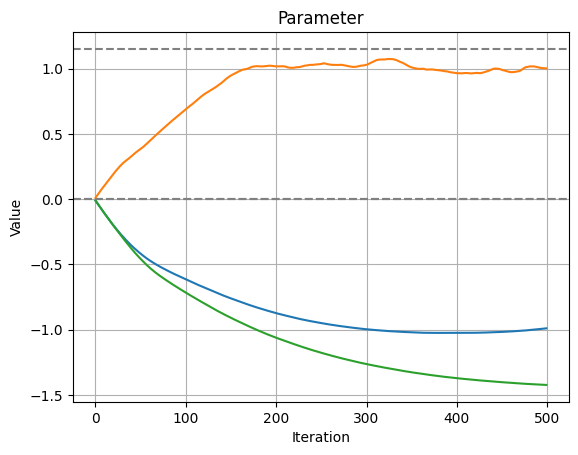

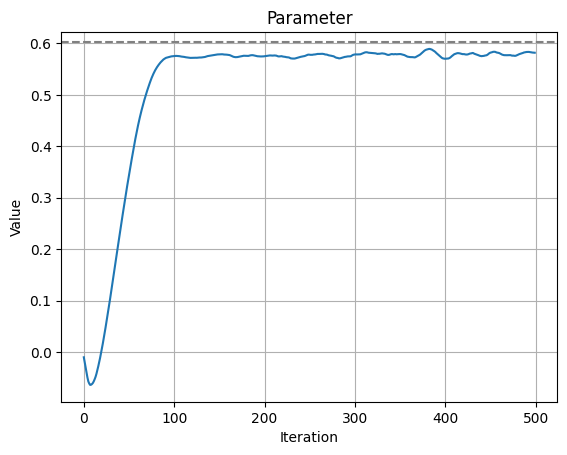

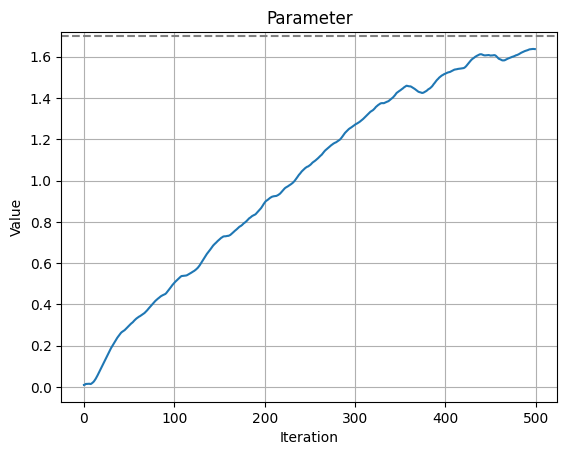

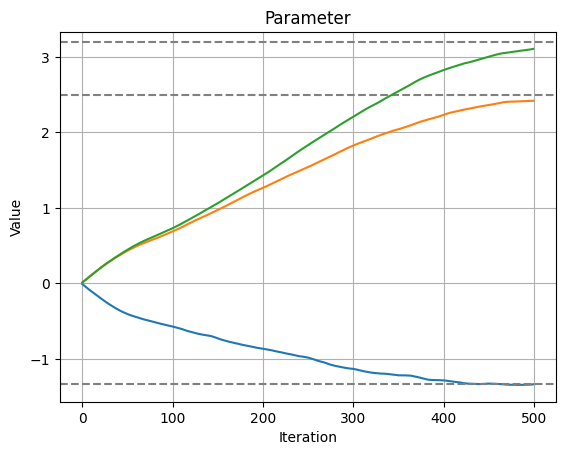

In [14]:
real_params_list = real_params.as_list

for i in range(len(history[0])):
    history_vstack = np.vstack([elt[i].numpy().reshape(1, -1) for elt in history])

    for j in range(history_vstack.shape[1]):
        plt.plot(np.arange(history_vstack.shape[0]), history_vstack[:, j])
        plt.axhline(y=float(real_params_list[i][j]), linestyle="--", color="gray")

    plt.title("Parameter")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

In [15]:
print("Estimation")
print(model.params_)

print(model.params_.get_cov("Q"))

Estimation
ModelParams(gamma=tensor([ 1.7970, -0.5413,  1.6137]), Q_repr=(tensor([-0.9894,  1.0019, -1.4230]), 'diag'), R_repr=(tensor([0.5818]), 'ball'), alphas={(0, 1): tensor([1.6368])}, betas={(0, 1): tensor([-1.3375,  2.4185,  3.1048])})
tensor([[ 7.2341,  0.0000,  0.0000],
        [ 0.0000,  0.1348,  0.0000],
        [ 0.0000,  0.0000, 17.2189]])


In [16]:
# Generate test individual

torch.manual_seed(12345)

n_test = 1

# Generate training set
c_test = torch.rand(n_test) * 5 + 10
x_test = torch.randn(n_test, p)
b_test = torch.randn(n_test, real_params.gamma.shape[0]) @ torch.linalg.cholesky(Q)
psi_test = f(real_params.gamma, x_test, b_test)

trajectories_init_test = [[(0.0, 0)] for _ in range(n_test)]

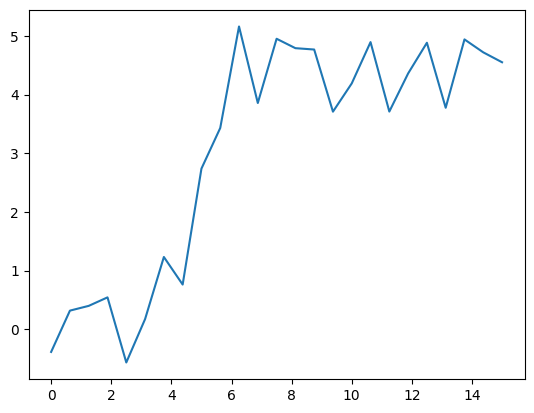

In [17]:
y_test = model_design.regression_fn(t, psi_test)
y_test += torch.randn_like(y_test) @ torch.linalg.cholesky(R)
plt.plot(t, y_test.squeeze(-1).T)
plt.show()

In [18]:
log_probs = []

prediction_times = torch.linspace(2.0, 6.0, 5)

for time in prediction_times:
    c_test = torch.full((n_test,), time)

    sample_test_data = SampleData(
        x_test,
        trajectories_init_test,
        psi_test,
        c_test,
    )

    u = c_test.view(-1, 1) + torch.linspace(0, 4, 50).view(1, -1)

    log_probs.append(real_model.compute_surv_log_probs(sample_test_data, u))

In [19]:

log_probs_pred = []

for time in prediction_times:
    c_test = torch.full((n_test,), time)

    pred_test_data = ModelData(
        x_test,
        t[t <= time],
        y_test[:, t <= time, :],
        trajectories_init_test,
        c_test
    )

    u = c_test.view(-1, 1) + torch.linspace(0, 4, 50).view(1, -1)

    log_probs_pred.append(model.predict_surv_log_probs(pred_test_data, u, n_iter_b=1000))


Predicting survival log probabilities:   8%|▊         | 84/1000 [00:00<00:03, 295.44it/s]


KeyboardInterrupt: 

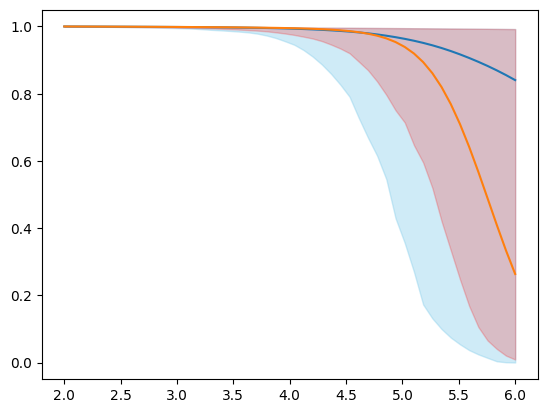

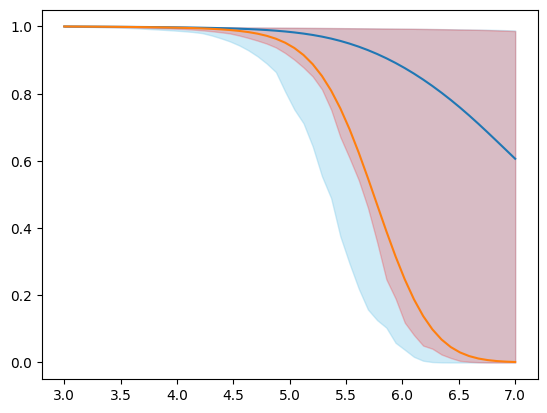

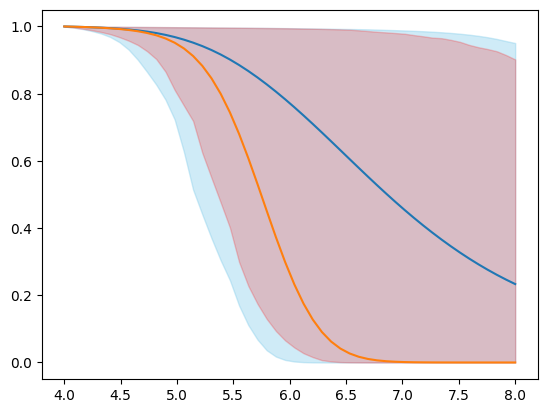

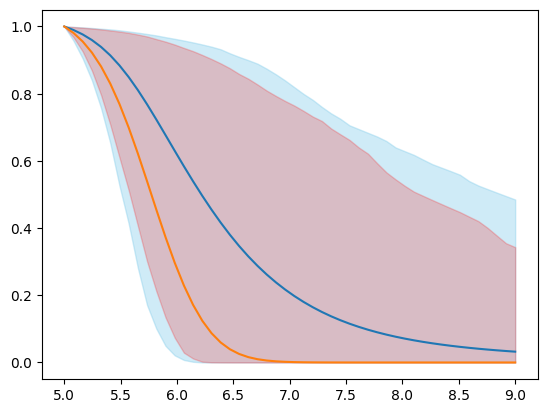

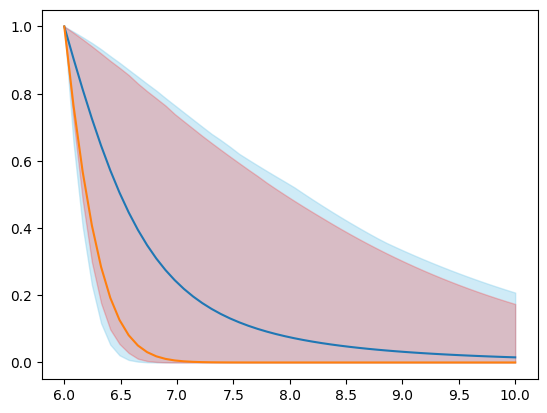

In [ ]:
for i, (lp, lpp) in enumerate(zip(log_probs, log_probs_pred)):
    probs_pred = torch.vstack([torch.exp(lpp[i][0].detach()) for i in range(len(lpp))]).numpy()

    bands = get_bands(probs_pred)
    pointwise = np.quantile(probs_pred, [0.025, 0.975], axis=0)

    points = prediction_times[i] + torch.linspace(0, 4, 50)

    plt.plot(points, probs_pred.mean(axis=0))
    plt.fill_between(points, bands["lower"], bands["upper"],
                    color="skyblue",
                    alpha=0.4)
    plt.fill_between(points, pointwise[0], pointwise[1],
                    color="red",
                    alpha=0.2)
    plt.plot(points, torch.exp(lp[0]).numpy())
    plt.show()